In [44]:
import sklearn
from sklearn.manifold import TSNE
import torch
import numpy as np
import os
import random
from improved_diffusion.unet import style_encoder_textedit_addskip
from PIL import Image
from scripts.image_sample import resize_image
from matplotlib import pyplot as plt

In [45]:
from torch import nn
import torch.nn.functional as F

cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg19cut': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'N'],
}

class StyleEncoder(nn.Module):
    def __init__(self, sty_dim=128):
        super(StyleEncoder, self).__init__()
        # network layers setting
        self.features = make_layers(cfg['vgg11'], True)
        self.cont = nn.Linear(512, sty_dim)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        flat = x.view(x.size(0), -1)
        cont = self.cont(flat)

        return cont

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=False)]
            else:
                layers += [conv2d, nn.ReLU(inplace=False)]
            in_channels = v
    return nn.Sequential(*layers)

In [48]:
# style_encoder = style_encoder_textedit_addskip()
# style_encoder_state_dict = torch.load("models/CFG/checkpoint_epoch6.pth",map_location='cpu')['netStyleEncoder']
# style_encoder.load_state_dict(style_encoder_state_dict)
# 
style_encoder = StyleEncoder()
checkpoint = torch.load("chinese_styenc.ckpt", map_location='cpu')
tmp_dict = {}
for k, v in checkpoint.items():
    if k in style_encoder.state_dict():
        tmp_dict[k] = v
style_encoder.load_state_dict(tmp_dict)
#
style_encoder.to(torch.device("cuda:1"))


StyleEncoder(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [54]:
style_num = np.linspace(0,50,50,dtype=np.int64)
num_image_per_style = 500
style_encoding_list = []
style_encoding_tag = []
for style_index in style_num:
    style_path = os.path.join("datasets/CFG/seen_font500_800",str(style_index))
    available_characters_with_ext = os.listdir(style_path)
    chosen = random.choices(available_characters_with_ext,k=num_image_per_style)
    for i in range(num_image_per_style):
        gt_image = Image.open(os.path.join(style_path, chosen[i]))
        gt_image = resize_image(gt_image,128).to(torch.device("cuda:1")).unsqueeze(0)
        #print(gt_image.shape)
        out = style_encoder(gt_image)
        #print(out.shape)
        style_encoding_list.append(out.detach())
        style_encoding_tag.append(style_index)

In [55]:
style_encoding = torch.stack(style_encoding_list).cpu().squeeze()
print(style_encoding.shape)
tsne = TSNE()
tsne_out = tsne.fit_transform(style_encoding)

torch.Size([40000, 128])


In [59]:
def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
 
    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig

In [60]:
print(tsne_out.shape)

(40000, 2)


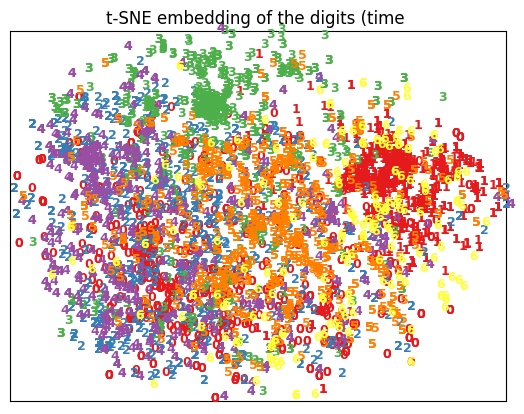

In [63]:


fig = plot_embedding(tsne_out[0:5000], style_encoding_tag[0:5000],
                         't-SNE embedding of the digits (time ')
plt.show(fig)